In [3]:
from pymongo import MongoClient
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string
import operator
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams 

In [4]:
client = MongoClient('localhost', 27017)
db = client.Manhattan_Twitter_db
collection = db.twitter_collection

In [5]:
type(collection)

pymongo.collection.Collection

In [9]:
twitters = []
for twitter in collection.find():
    twitters.append(twitter['text'])

In [10]:
len(twitters)

60301

In [13]:

word_data = pd.Series(twitters).to_frame(name="twitter")

In [14]:
word_data['loc'] = "Manhattan"

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string

rem = string.digits + '/\-+.'
rem_chars = lambda a: ''.join([i for i in a if i not in rem])
word_data['twitter'] = word_data['twitter'].apply(rem_chars)


In [17]:
stop_words = ENGLISH_STOP_WORDS

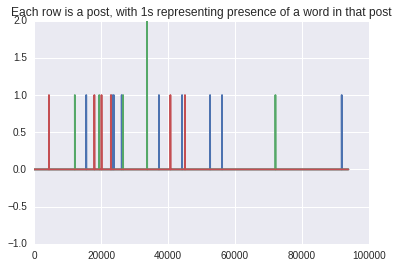

In [21]:
vec = CountVectorizer(max_df=.6, stop_words=stop_words)
vec_tar = LabelEncoder()

counts = vec.fit_transform(word_data['twitter'])
targets = vec_tar.fit_transform(word_data['loc'])
plt.plot(counts[:3].toarray().T)
plt.ylim([-1, 2])
plt.title('Each row is a post, with 1s representing presence of a word in that post')

In [31]:
top_words = {}
for itrg in np.unique(targets):
    loc = vec_tar.classes_[itrg]
    # Pull only the data points assigned to the current loction
    icounts = counts[targets == itrg, :].sum(0).squeeze()
    
    # Which counts had at least five occurrences
    msk_top_words = icounts > 400
    
    # The inverse transform turns the vectors back into actual words
    top_words[loc] = vec.inverse_transform(msk_top_words)[0]

In [32]:
top_words

{'Manhattan': array(['amp', 'apply', 'avenue', 'best', 'better', 'birthday', 'black',
        'brooklyn', 'careerarc', 'check', 'city', 'cleared', 'click',
        'come', 'construction', 'day', 'days', 'did', 'don', 'exit', 'feel',
        'fit', 'fuck', 'getting', 'going', 'gonna', 'good', 'got', 'great',
        'halloween', 'happy', 'help', 'hillary', 'hillaryclinton', 'hiring',
        'home', 'https', 'im', 'incident', 'job', 'jobs', 'join', 'just',
        'know', 'latest', 'let', 'life', 'like', 'live', 'll', 'lmao',
        'lol', 'look', 'looking', 'love', 'make', 'man', 'manhattan',
        'need', 'new', 'newyork', 'night', 'nj', 'ny', 'nyc', 'oh',
        'opening', 'people', 'pm', 'read', 'real', 'realdonaldtrump',
        'really', 'recommend', 'right', 'said', 'say', 'shit', 'st', 'stop',
        'street', 'team', 'th', 'thank', 'thanks', 'thing', 'think', 'time',
        'today', 'tonight', 'trump', 'update', 've', 'vote', 'wait', 'want',
        'way', 'week', 'work',

In [6]:
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 

In [7]:
punctuation = list(string.punctuation)
stop_words = ENGLISH_STOP_WORDS
stop = stopwords.words('english') + punctuation + ['rt', 'via','amp'] + list(stop_words)
count_bigram=Counter()

In [10]:
search_word = "nyc" # pass a term as a command-line argument
count_search = Counter()
for twitter in collection.find():
    tweet = twitter["text"]
    tweet = tweet.lower()
    terms_only = [term for term in preprocess(tweet)
                  if term not in stop
                  and not term.startswith(('#', '@'))]
    if search_word in terms_only:
        count_search.update(terms_only)
print("Co-occurrence for %s:" % search_word)
print(count_search.most_common(20))


Co-occurrence for nyc:
[('nyc', 965), ('…', 228), ('new', 74), ('park', 66), ('central', 58), ("i'm", 51), ('️', 49), ('ny', 46), ('york', 43), ('square', 41), ('day', 40), ('11', 38), ('times', 38), ("it's", 34), ('time', 34), ('2', 33), ('❤', 32), ('9', 30), ('center', 29), ('love', 28)]
